### This notebook is for the cryotempo eolis point data processing.


In [29]:
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from utils.transform_time import second_to_dyr
import xarray as xr
import numpy as np



In [30]:
path_2021_raw = 'data/cryosat-2/eolis-point-2021/raw/01/SOUASIAEA/CS_OFFL_THEM_POINT_SOUASIAEA_2021_01_+77611426_+30446348_V201.nc'
path_2021_readout = 'data/cryosat-2/eolis-point-2021/readout/CS_OFFL_THEM_POINT_CENTRASIA_2021_01_+90119057_+27885152_V201_readout_subs.h5'
path_2012_tile = 'data/cryosat-2/eolis-point-2012/tiles/tile_29_95.h5'
path_2021_tile = 'data/cryosat-2/eolis-point-2021/tiles/tile_29_96.h5'
path_dif_tile = 'data/cryosat-2/tiles-dif-srtm/tile_29_96.h5'
path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'


In [3]:
data_raw = xr.open_dataset(path_2021_raw)
data_raw

<xarray.Dataset>
Dimensions:        (row: 9)
Coordinates:
    lon            (row) float32 ...
    lat            (row) float32 ...
Dimensions without coordinates: row
Data variables:
    time           (row) int32 ...
    elevation      (row) float32 ...
    uncertainty    (row) float32 ...
    is_swath       (row) int32 ...
    input_file_id  (row) int32 ...
Attributes: (12/34)
    cdm_data_type:           Point
    Conventions:             CF-1.7
    Metadata_Conventions:    Unidata Dataset Discovery v1.0
    contact:                 support@cryotempo-eolis.org
    creator_email:           support@cryotempo-eolis.org
    creator_url:             http://cryotempo-eolis.org/
    ...                      ...
    references:              Spatially and temporally resolved ice loss in Hi...
    source:                  Swath data generated from CryoSat-2 SARIn data.
    time_coverage_duration:  P1M
    time_coverage_start:     2021-01-07T10:09:15
    time_coverage_end:       2021-01-07T10:09:15
    fileids:                 ['15338436 : CS_OFFL_SIR_SIN_1B_20210107T100915_...

In [4]:
print('---------- readout:')
!h5ls $path_2021_readout
print('---------- readout 2012 tile:')
!h5ls $path_2012_tile
print('---------- readout 2021 tile:')
!h5ls $path_2021_tile


---------- readout:
h                        Dataset {12}
input_file_id            Dataset {12}
is_swath                 Dataset {12}
lat                      Dataset {12}
lon                      Dataset {12}
t_dyr                    Dataset {12}
uncertainty              Dataset {12}
---------- readout 2012 tile:
h                        Dataset {2404}
input_file_id            Dataset {2404}
is_swath                 Dataset {2404}
lat                      Dataset {2404}
lon                      Dataset {2404}
t_dyr                    Dataset {2404}
uncertainty              Dataset {2404}
---------- readout 2021 tile:
h                        Dataset {31399}
input_file_id            Dataset {31399}
is_swath                 Dataset {31399}
lat                      Dataset {31399}
lon                      Dataset {31399}
t_dyr                    Dataset {31399}
uncertainty              Dataset {31399}


In [31]:
cryo_2012_tile = h5py.File(path_2012_tile,'r')
cryo_2021_tile = h5py.File(path_2021_tile,'r')
cryo_dif_tile =  h5py.File(path_dif_tile,'r')


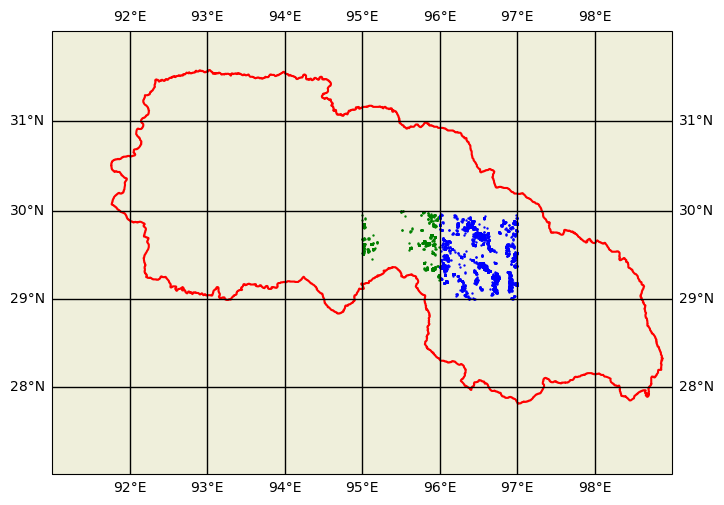

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([91, 99, 27.0, 32.0])
ax.add_feature(cfeature.LAND); 
ax.gridlines(draw_labels=True, linewidth=1, alpha=1, zorder=1, color='black')
## 1. setp boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='red', linewidth=1.5, facecolor='none')
ax.add_feature(shp_fea, zorder=0)

# 2.1. cryotempo points readout file
ax.scatter(x=cryo_2012_tile['lon'][:], y=cryo_2012_tile['lat'][:], c='green', s=0.5, \
                                                  transform=ccrs.PlateCarree(), zorder=0)
# 2.2. cryotempo points tile-based data
ax.scatter(x=cryo_2021_tile['lon'][:], y=cryo_2021_tile['lat'][:], c='blue', s=0.5, transform=ccrs.PlateCarree(), zorder=0)



In [32]:
ele_2012_tile = cryo_2012_tile['h'][:]
ele_2021_tile = cryo_2021_tile['h'][:]
ele_2021_tile_uncertainty = cryo_2021_tile['uncertainty'][:]
time_2021_tile = cryo_2021_tile['t_dyr'][:]
print(ele_2021_tile)
print(time_2021_tile )
print(ele_2021_tile_uncertainty)

[5257.716  5257.2104 5306.6    ... 5019.613  5024.2124 5062.6123]
[2021.1855 2021.1855 2021.1855 ... 2021.9907 2021.9907 2021.9907]
[23.808643 23.808643       nan ... 16.24446  23.350628 23.100513]


20234.72

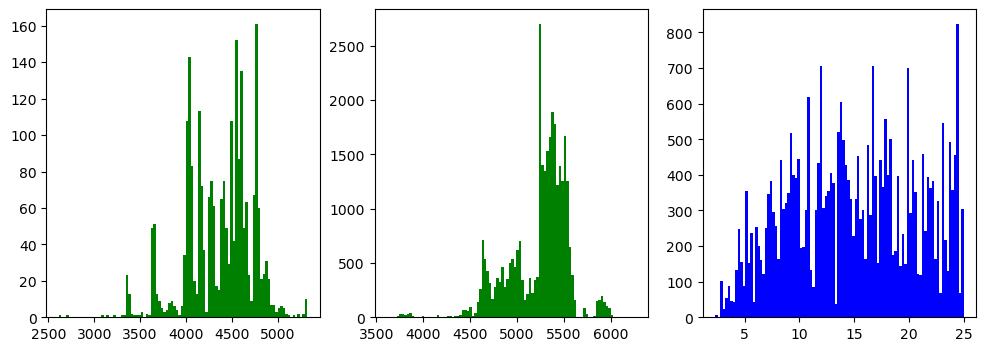

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
count_bin = plt.hist(ele_2012_tile, bins=100, color='green')
plt.subplot(1,3,2)
count_bin = plt.hist(ele_2021_tile, bins=100, color='green')
plt.subplot(1,3,3)
count_bin = plt.hist(ele_2021_tile_uncertainty , bins=100, color='blue')



#### Comparison bettween the swath data and cryosat-2 l2 data.

<KeysViewHDF5 ['h', 'h_dif', 'h_srtm', 'is_swath', 'lat', 'lon', 't_dyr', 'type_fp']>


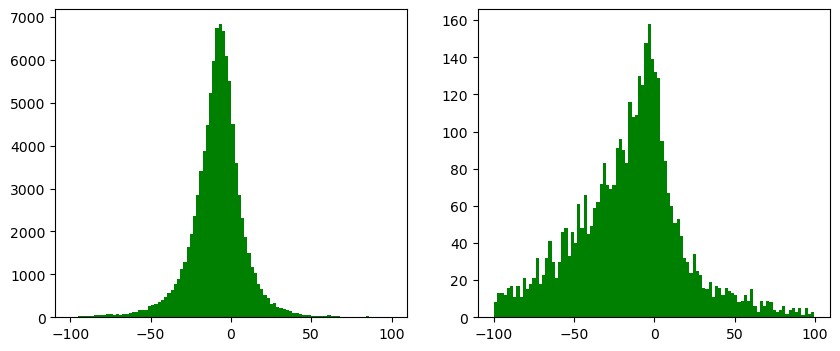

In [42]:
print(cryo_dif_tile.keys())
id_l2 = np.where(cryo_dif_tile['is_swath'][:]==0)[0]
id_swath = np.where(cryo_dif_tile['is_swath'][:]==1)[0]
ele_dif_swath = cryo_dif_tile['h_dif'][id_swath]
ele_dif_l2 = cryo_dif_tile['h_dif'][id_l2]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
count_bin = plt.hist(ele_dif_swath, bins=100, color='green')
plt.subplot(1,2,2)
count_bin = plt.hist(ele_dif_l2, bins=100, color='green')
